<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [3]:
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

 99% 584M/592M [00:04<00:00, 115MB/s]
100% 592M/592M [00:04<00:00, 126MB/s]


In [4]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  
  inflating: /content/data/twitter_data/all_twitter_data.csv  
  inflating: /content/data/twitter_data/political_twitter_data.csv  


In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from operator import itemgetter

import re
import tweepy
from tweepy import OAuthHandler
from config import TwitterKeys

In [6]:
consumer_key = TwitterKeys.consumer_key
consumer_secret = TwitterKeys.consumer_secret
access_token = TwitterKeys.access_token
access_token_secret = TwitterKeys.access_token_secret

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tweepy.API(auth,  wait_on_rate_limit=True)

twitter_app_auth = {
    'consumer_key': consumer_key,
    'consumer_secret': consumer_secret,
    'access_token': access_token,
    'access_token_secret': access_token_secret,
  }

In [7]:
pol_df = pd.read_csv('/content/data/clean_twitter_data/pol_actor_users.csv', index_col=0)

In [73]:
interactions_df = pd.DataFrame(columns=['user_username', 'mentioned_users'])
user = []
mentions = []
for row in pol_df.iterrows():
  user.append(row[1]['user_username'])
  mentions.append(row[1]['mentioned_users'])
interactions_df['user_username'] = user
interactions_df['mentioned_users'] = mentions
interactions_df['mentioned_users'] = interactions_df['mentioned_users'].str.split()

In [94]:
interactions = []
for row in interactions_df.iterrows():
  user = row[1][0]
  mentions = row[1][1]
  for mention in mentions:
    interactions.append((user, mention))

In [135]:
interactions_df = pd.DataFrame(interactions, columns=['user_username', 'mentioned_users'])

In [136]:
interactions_df

,user_username,mentioned_users
0,AdamAfriyie,nan
1,AdamAfriyie,"[['MarkVivis'],"
2,AdamAfriyie,['GregHands']]
3,AdamAfriyie,nan
4,AdamFMcGregor,[['nottsgreenparty']]
...,...,...
19535,LeedsCityTories,['EandRTories']]
19536,LeedsCityTories,"[['PudseyCons'],"
19537,LeedsCityTories,['EandRTories']]
19538,LeedsCityTories,"[['PudseyCons'],"


In [174]:
interactions_df = interactions_df.replace('nan', np.nan)
interactions_df = interactions_df.dropna()

In [176]:
interactions_df['user_username'] = interactions_df['user_username'].astype('str')
interactions_df['mentioned_users'] = interactions_df['mentioned_users'].astype('str')

In [202]:
interactions_df=interactions_df.drop([1,2])

In [205]:
graph = nx.from_pandas_edgelist(interactions_df, 'user_username', 'mentioned_users')
pos = nx.spring_layout(graph)


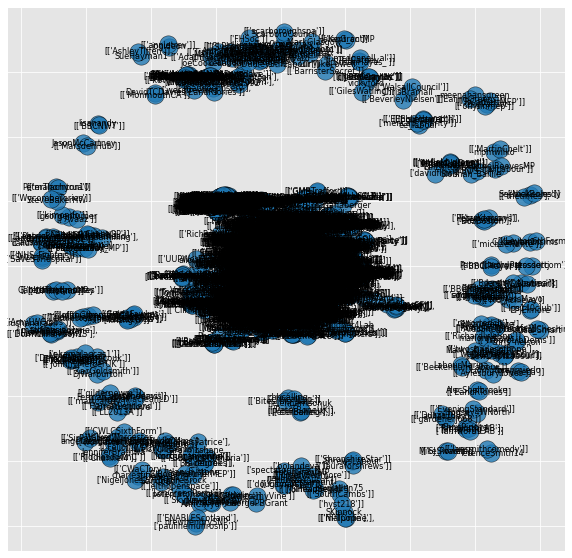

In [206]:
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(graph, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(graph, pos, font_size=8)
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)

In [207]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 2676 nodes and 3253 edges present in the Graph
The maximum degree of the Graph is 184
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 2.4
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 104 connected components in the Graph


In [208]:
largest_subgraph=list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

    
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

There are 2336 nodes and 3016 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0
The diameter of our Graph is 14
The average distance between any two nodes is 5.43


In [209]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id DrTeckKhong has a degree centrality of 0.08 which is the maximum of the Graph
the node with id [['theresa_may']] has a closeness centrality of 0.29 which is the maximum of the Graph
the node with id [['theresa_may']] has a betweenness centrality of 0.19 which is the maximum of the Graph


In [214]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = ['DrTeckKhong',"[['theresa_may']]"]
pos = nx.spring_layout(largest_subgraph, k=0.05)

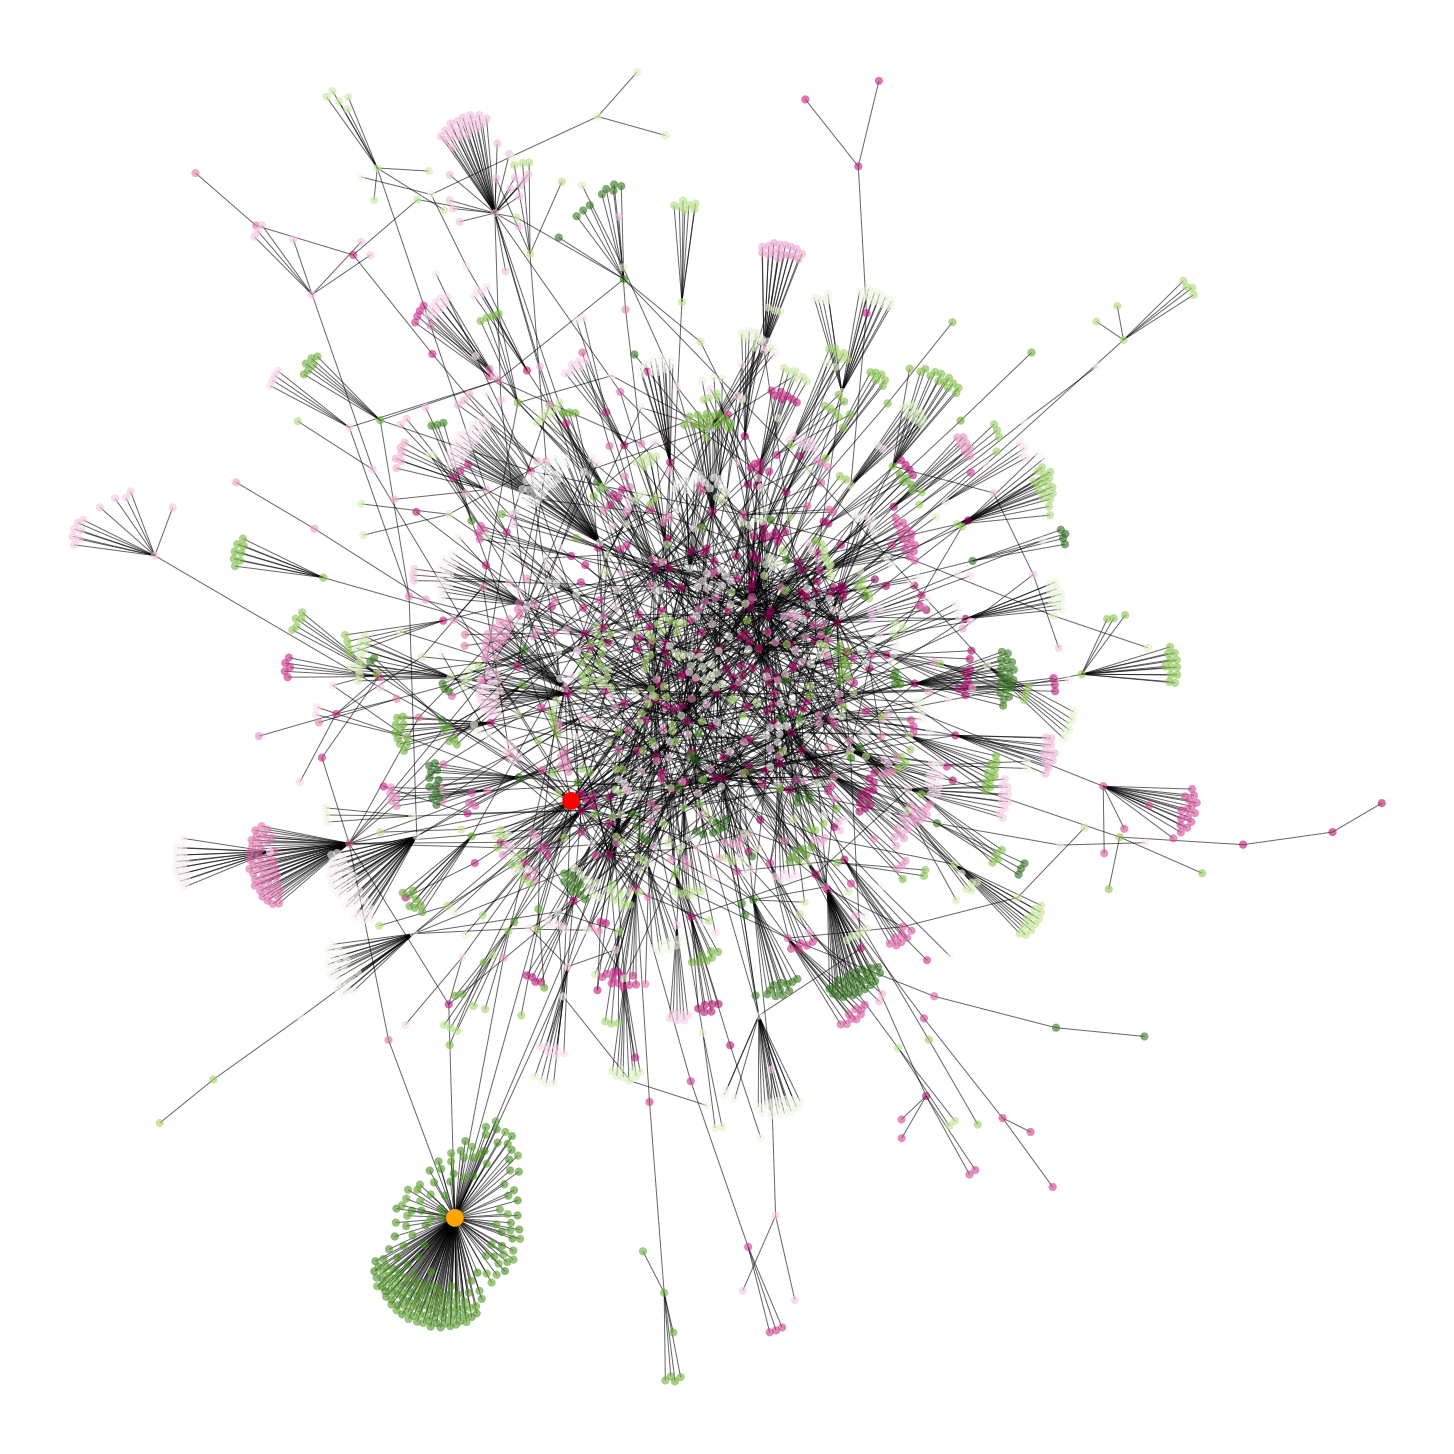

In [215]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(2336), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.show()

In [219]:
from community import community_louvain
partition = community_louvain.best_partition(largest_subgraph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

In [220]:
G_sorted = pd.DataFrame(sorted(largest_subgraph.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

In [221]:
combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")

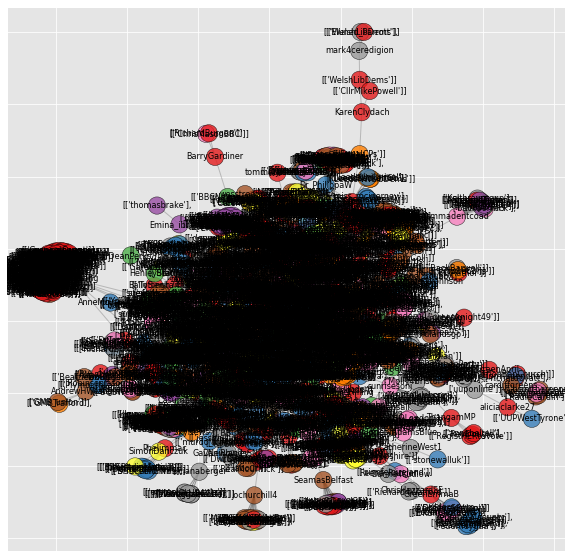

In [223]:
pos = nx.spring_layout(largest_subgraph)
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(largest_subgraph, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8)
nx.draw_networkx_edges(largest_subgraph, pos, width=1.0, alpha=0.2)

In [225]:
edges = nx.to_pandas_edgelist(largest_subgraph)
edges.to_csv("edges.csv")

combined = combined.rename(columns={"names": "Id"})
nodes = combined['Id']
combined.to_csv('nodes.csv')